In [1]:
import openai
import dotenv
import os

dotenv.load_dotenv()

client = openai.OpenAI(
  api_key=os.getenv("HYPERBOLIC_API_KEY"),
  base_url="https://api.hyperbolic.xyz/v1/",
)

In [2]:
user_content = "For a 3 sets' tennis game, would you bet on it finishing in 2 sets or 3 sets, assuming each player has an equal probability of winning a set?"
user_content = "Is 1027 a prime number?"

chat_completion = client.chat.completions.create(
    # model="meta-llama/Meta-Llama-3.1-8B-Instruct",
    # model="deepseek-ai/DeepSeek-V2.5",
    model= "Qwen/Qwen2.5-72B-Instruct",
    messages=[
        # {"role": "system", "content": system_content},
        {"role": "user", "content": user_content},
    ],
    temperature=0.7,
    max_tokens=1024,
    # logprobs=True,
    # top_logprobs=20,
)


In [3]:
import pprint

pprint.pprint(chat_completion.choices[0].message.content)

('To determine if 1027 is a prime number, we need to check if it has any '
 'divisors other than 1 and itself. A prime number is a number greater than 1 '
 'that has no positive divisors other than 1 and itself.\n'
 '\n'
 "Let's check for divisibility by the prime numbers up to the square root of "
 '1027. The square root of 1027 is approximately 32.05, so we only need to '
 'check for divisibility by prime numbers less than or equal to 31.\n'
 '\n'
 '1. **Divisibility by 2**: 1027 is odd, so it is not divisible by 2.\n'
 '2. **Divisibility by 3**: Sum of the digits of 1027 is \\(1 + 0 + 2 + 7 = '
 '10\\), which is not divisible by 3, so 1027 is not divisible by 3.\n'
 '3. **Divisibility by 5**: 1027 does not end in 0 or 5, so it is not '
 'divisible by 5.\n'
 '4. **Divisibility by 7**: Perform the division \\(1027 \\div 7 \\approx '
 '146.714\\), which is not an integer, so 1027 is not divisible by 7.\n'
 '5. **Divisibility by 11**: Alternating sum of the digits is \\(1 - 0 + 2 - 7 '


In [4]:
from pathlib import Path
import torch

from entropix.config import LLAMA_1B_PARAMS
from entropix.tokenizer import Tokenizer
from entropix.torch_kvcache import KVCache
from entropix.torch_main import precompute_freqs_cis
from entropix.torch_weights import load_weights
from entropix.torch_model import xfmr

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with torch.inference_mode():
    model_params = LLAMA_1B_PARAMS
    xfmr_weights = load_weights(ckpt_dir=Path("weights/1B-Base"), should_compare_outputs=True)

    tokenizer = Tokenizer('entropix/tokenizer.model')
    bsz = 1
    kvcache = KVCache.new(model_params.n_layers, bsz, model_params.max_seq_len, model_params.n_local_kv_heads, model_params.head_dim).to(DEVICE)


Using device: cuda

In [5]:
prefill_str = f"""<|begin_of_text|><|start_header_id|>user<|end_header_id|>
{user_content}
<|eot_id|><|start_header_id|>assistant<|end_header_id|>"""
prefill_tokens = tokenizer.encode(prefill_str, bos=False, eos=False, allowed_special='all')

result_str = f"""{chat_completion.choices[0].message.content}<|eot_id|>"""
result_tokens = tokenizer.encode(result_str, bos=False, eos=False, allowed_special='all')

joined_str = prefill_str + "\n" + result_str

joined_tokens = tokenizer.encode(joined_str,  bos=False, eos=False, allowed_special='all')

In [6]:
# single pass

from entropix.torch_main import build_attn_mask, precompute_freqs_cis
from entropix.torch_model import xfmr

tokens = torch.tensor([joined_tokens], dtype=torch.long).to(DEVICE)
seqlen = tokens.size(1)

cur_pos = 0
freqs_cis = precompute_freqs_cis(model_params.head_dim, model_params.max_seq_len, model_params.rope_theta, model_params.use_scaled_rope) 
attn_mask = build_attn_mask(seqlen, cur_pos)
bsz, seqlen = tokens.shape

with torch.inference_mode():
    logits, kvcache, scores, _ = xfmr(xfmr_weights, model_params, tokens, cur_pos, freqs_cis[:seqlen], kvcache, attn_mask=attn_mask)


In [24]:
from entropix.torch_sampler import calculate_metrics


stats_arr = []

for i in range(len(prefill_tokens), len(joined_tokens) - 1):
    ground_truth_token_str = tokenizer.decode([joined_tokens[i + 1]]).encode("unicode_escape").decode("utf-8")
    
    # compute statistics for each token
    mx = calculate_metrics(logits[:, i, :], scores[:, :, :i, :i], i)
    mx_clean = {k: v.item() for k, v in mx.items()}

    mx_results = {}

    # what is the probability of the ground truth token, in the model's output?
    prob = torch.nn.functional.softmax(logits[:, i, :], dim=-1)
    prob_gt = prob[0, joined_tokens[i+1]].item()
    mx_results["prob"] = prob_gt

    # what is the rank of the ground truth token?
    _, topk = torch.topk(prob, k=10000, dim=-1)
    topk = topk[0].tolist()
    try:
        mx_results["rank"] = topk.index(joined_tokens[i+1])
    except ValueError:
        mx_results["rank"] = -1

    # what was the top greedy token?
    mx_results["top1"] = tokenizer.decode([topk[0]]).encode("unicode_escape").decode("utf-8")

    outcome = ""
    if mx_results["rank"] == 0 and mx_results["prob"] > 0.75:
        # this, in practice, might just be adaptive sample
        outcome = "greedy"
    elif mx_results["rank"] < 10:
        if (mx_clean["logits_entropy"] ** 2) > mx_clean["logits_varentropy"]:
            outcome = "clarify"
        else:
            outcome = "fork"
    else:
        outcome = "resample"

    mx_dict = mx_clean | mx_results
    mx_dict['outcome'] = outcome
    mx_dict['token'] = ground_truth_token_str
    stats_arr.append(mx_dict)
    print(f"{ground_truth_token_str}\t {outcome}\t {mx_results}\t{mx_clean}")


To	 resample	 {'prob': 0.00070953369140625, 'rank': 74, 'top1': 'Is'}	{'logits_entropy': 12.0, 'logits_varentropy': 23.75, 'logits_skewness': -0.111328125, 'logits_kurtosis': -0.09375, 'attn_entropy': 2.140625, 'attn_varentropy': 0.61328125, 'attn_skewness': -0.455078125, 'attn_kurtosis': -1.21875, 'agreement': 0.0361328125, 'interaction_strength': 2.484375}
 determine	 resample	 {'prob': 0.00994873046875, 'rank': 10, 'top1': ' '}	{'logits_entropy': 8.3125, 'logits_varentropy': 20.75, 'logits_skewness': 0.53515625, 'logits_kurtosis': 0.953125, 'attn_entropy': 2.1875, 'attn_varentropy': 0.66015625, 'attn_skewness': -0.43359375, 'attn_kurtosis': -1.25, 'agreement': 0.034912109375, 'interaction_strength': 2.46875}
 if	 fork	 {'prob': 0.33203125, 'rank': 1, 'top1': ' whether'}	{'logits_entropy': 1.9609375, 'logits_varentropy': 7.25, 'logits_skewness': 0.56640625, 'logits_kurtosis': 1.03125, 'attn_entropy': 2.1875, 'attn_varentropy': 0.64453125, 'attn_skewness': -0.34375, 'attn_kurtosis': -

In [26]:
import pandas as pd
import plotnine as pn

df = pd.DataFrame(stats_arr)
df['index'] = df.index + 0.1


In [29]:
df.tail(40)

,logits_entropy,logits_varentropy,logits_skewness,logits_kurtosis,attn_entropy,attn_varentropy,attn_skewness,attn_kurtosis,agreement,interaction_strength,prob,rank,top1,outcome,token,index
347,0.002686,0.044189,0.585938,1.500000,3.406250,1.632812,-0.218750,-0.582031,0.002075,6.03125,1.000000e+00,0,7,greedy,7,347.1
348,0.090820,1.062500,0.847656,2.125000,3.406250,1.632812,-0.217773,-0.582031,0.002075,6.03125,9.921875e-01,0,is,greedy,is,348.1
349,0.671875,3.156250,0.898438,2.156250,3.406250,1.632812,-0.215820,-0.585938,0.002060,6.00000,8.906250e-01,0,divisible,greedy,divisible,349.1
350,0.010681,0.164062,0.742188,1.750000,3.406250,1.640625,-0.213867,-0.585938,0.002060,6.03125,1.000000e+00,0,by,greedy,by,350.1
351,0.028687,0.367188,0.726562,1.375000,3.406250,1.640625,-0.215820,-0.585938,0.002060,6.06250,1.000000e+00,0,,greedy,,351.1
352,0.013550,0.171875,0.777344,3.437500,3.406250,1.640625,-0.215820,-0.582031,0.002045,6.03125,1.000000e+00,0,13,greedy,13,352.1
353,0.617188,2.656250,0.929688,2.531250,3.406250,1.640625,-0.215820,-0.582031,0.002045,6.03125,6.542969e-02,1,.\n,fork,.\n\n,353.1
354,5.375000,9.812500,1.039062,2.531250,3.421875,1.648438,-0.214844,-0.585938,0.002029,6.06250,4.956055e-02,4,Therefore,clarify,Since,354.1
355,2.859375,5.031250,0.878906,2.093750,3.421875,1.648438,-0.220703,-0.585938,0.002029,6.03125,4.531250e-01,0,,clarify,,355.1
356,0.421875,3.531250,1.429688,7.125000,3.437500,1.648438,-0.223633,-0.582031,0.002029,6.03125,9.609375e-01,0,102,greedy,102,356.1


/home/hua/code/entropix/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
/home/hua/code/entropix/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
/home/hua/code/entropix/.venv/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 1 rows containing missing values.


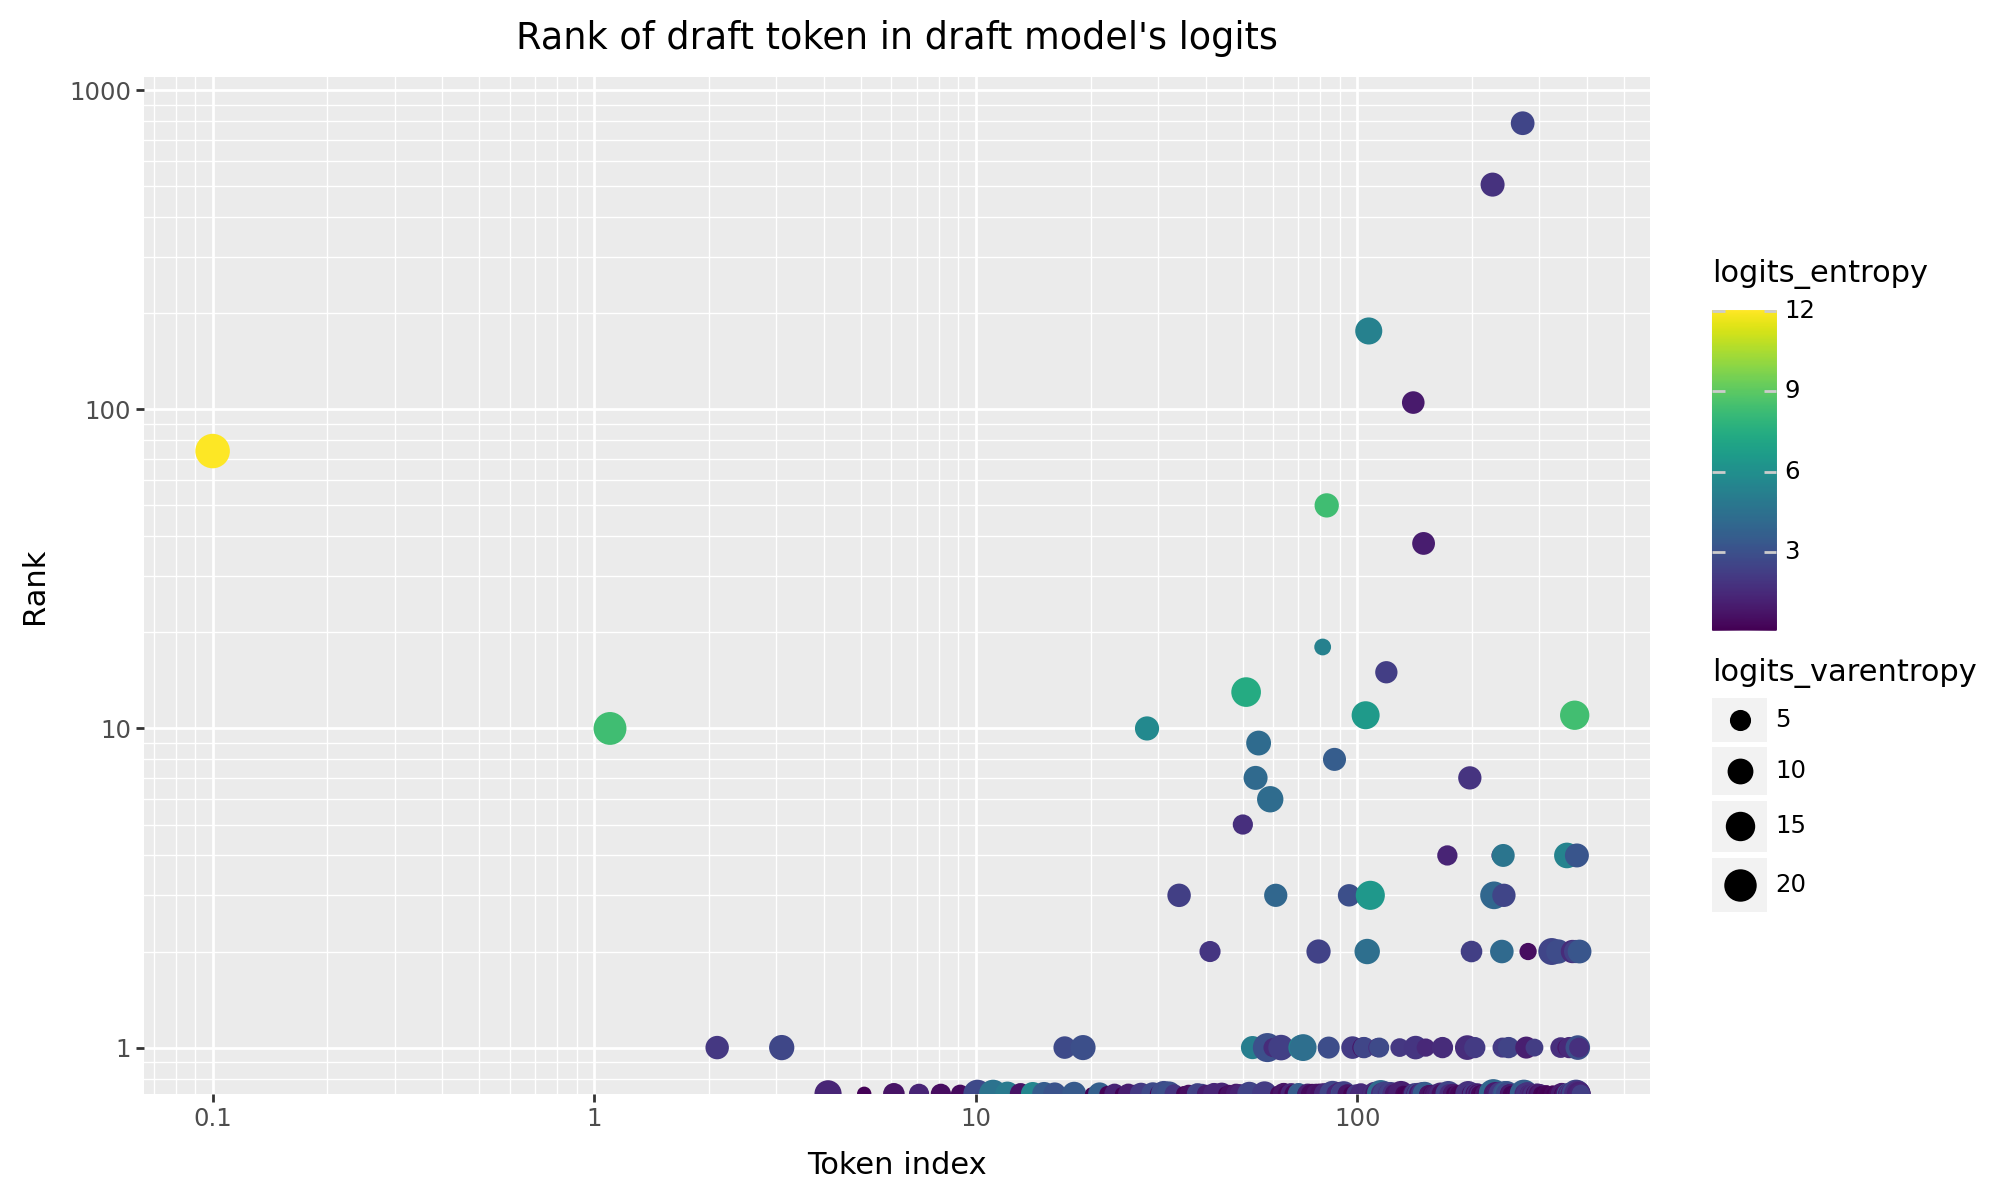

In [15]:
pn.ggplot(df, pn.aes(x="index", y="rank", color="logits_entropy", size="logits_varentropy")) + pn.geom_point() + pn.scale_x_log10() + pn.scale_y_log10() + pn.labs(title="Rank of draft token in draft model's logits", x="Token index", y="Rank") + pn.theme(figure_size=(10, 6)) 

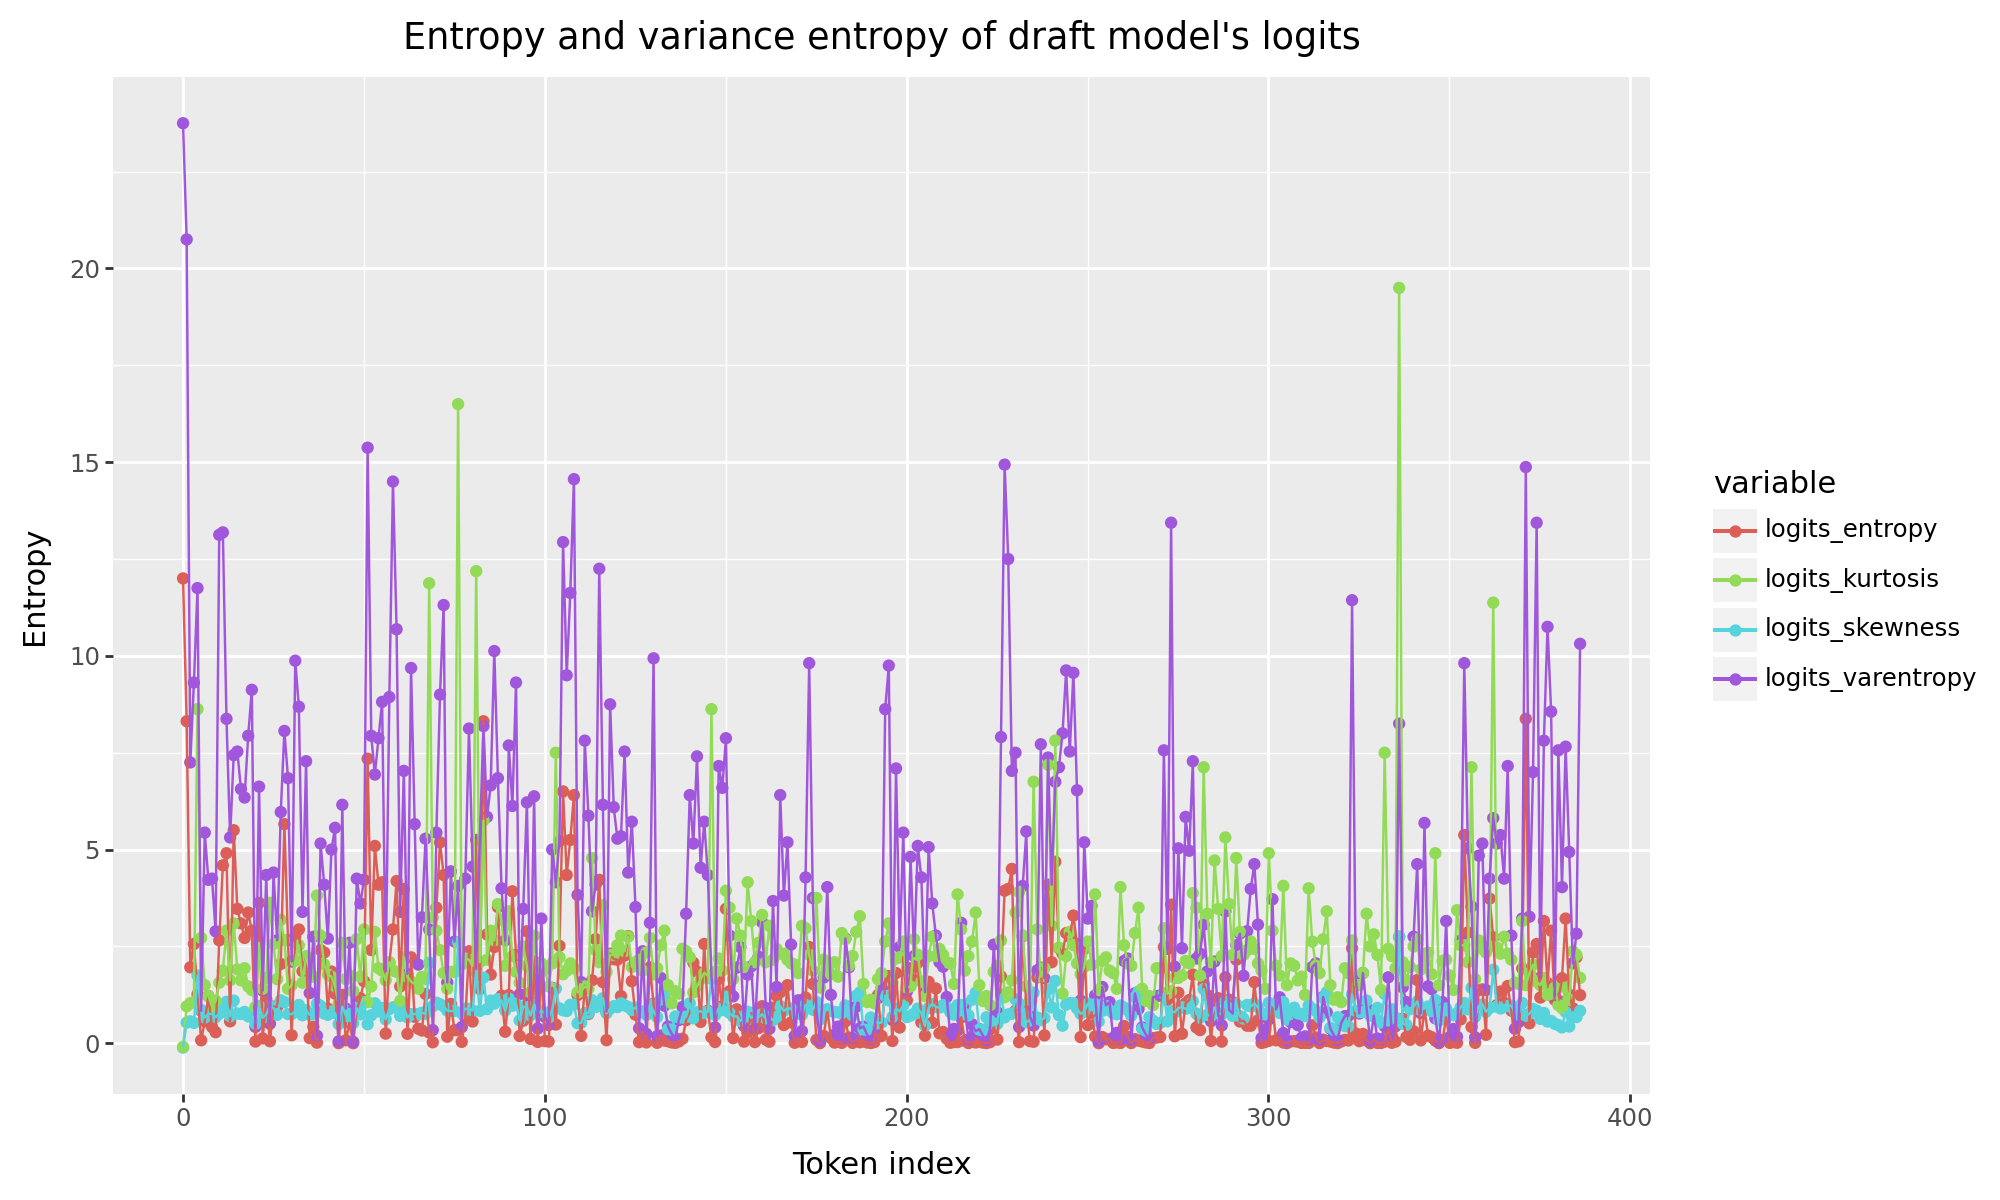

In [20]:
# plot timeseries of entropy and variance entropy and attn entropy and variance entropy

pn.ggplot(
    df.melt(id_vars="index", value_vars=["logits_entropy", "logits_varentropy", "logits_skewness", "logits_kurtosis"]),
    pn.aes(x="index", y="value", color="variable")
) + pn.geom_point() + pn.geom_line() + pn.labs(title="Entropy and variance entropy of draft model's logits", x="Token index", y="Entropy") + pn.theme(figure_size=(10, 6)) 

/home/hua/code/entropix/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
/home/hua/code/entropix/.venv/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 1 rows containing missing values.
/home/hua/code/entropix/.venv/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_text : Removed 1 rows containing missing values.


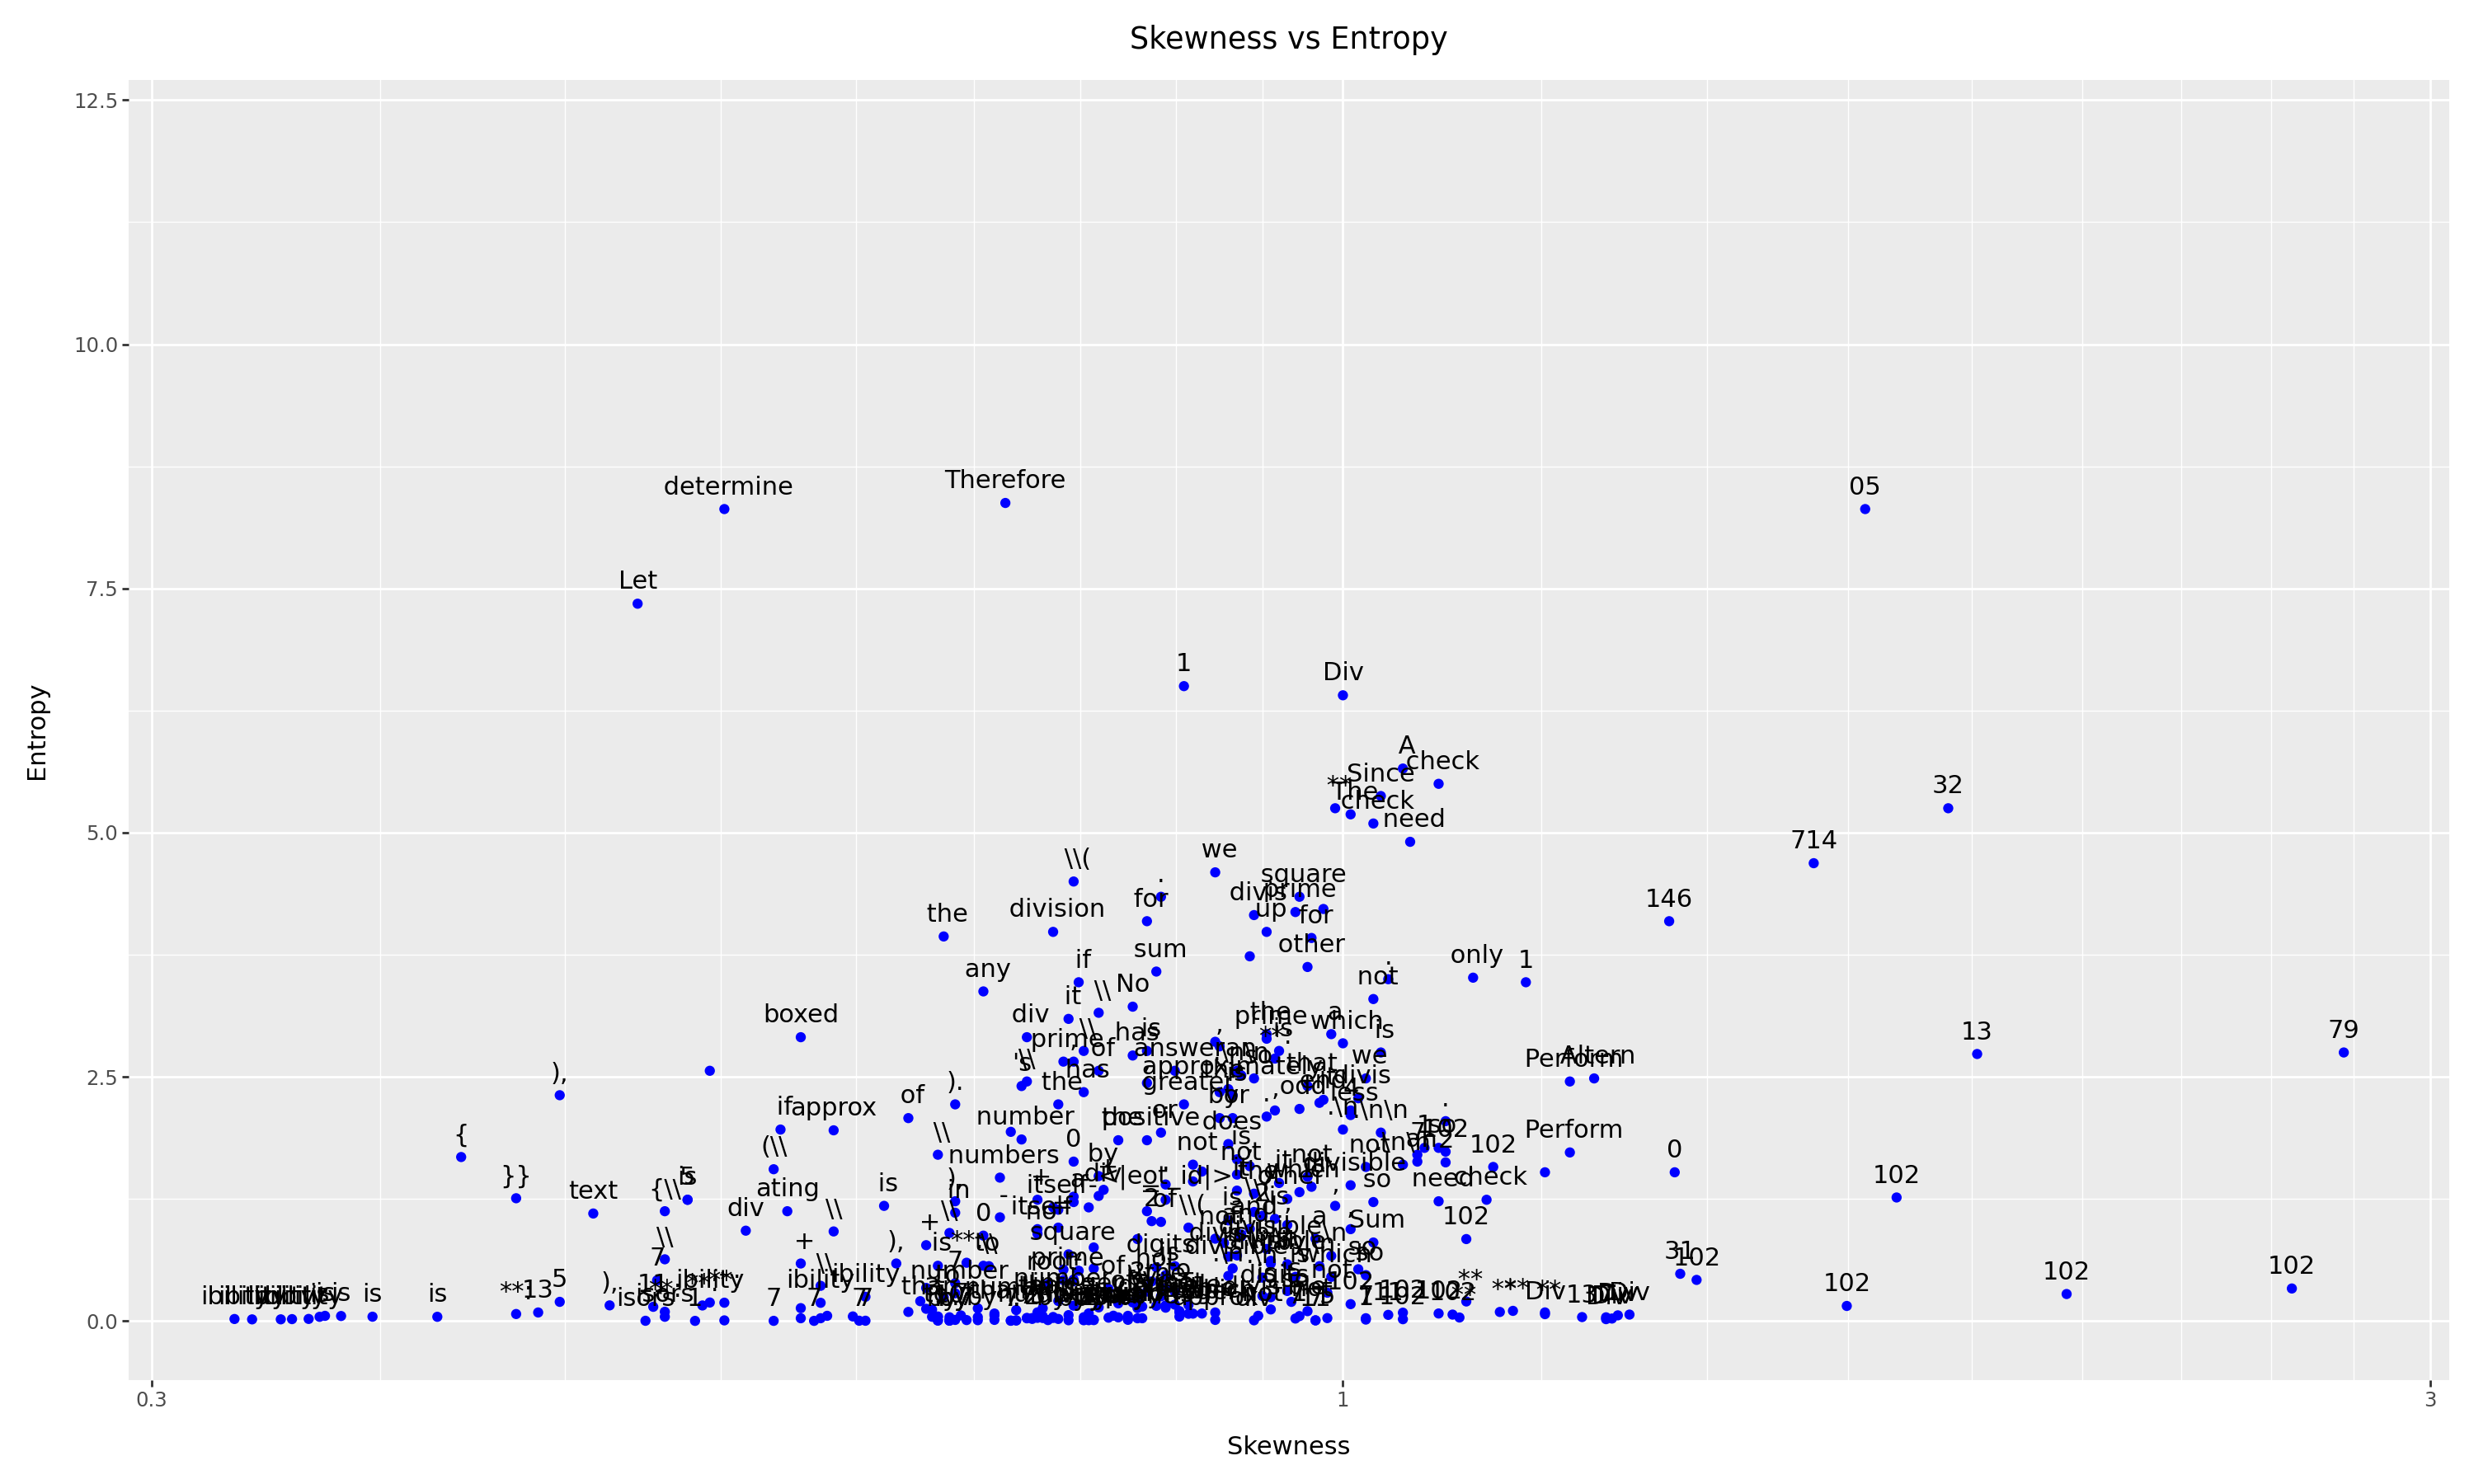

In [51]:
(pn.ggplot(df, 
               pn.aes(x='logits_skewness', 
                   y='logits_entropy')) 
    + pn.geom_point(color='blue')
    + pn.geom_text(pn.aes(label='token'), 
                va='bottom',
                ha='center',
                nudge_y=0.1)
    + pn.labs(
        title='Skewness vs Entropy',
        x='Skewness',
        y='Entropy'
    )
    + pn.scale_x_log10()
    + pn.theme(figure_size=(15, 9))
)

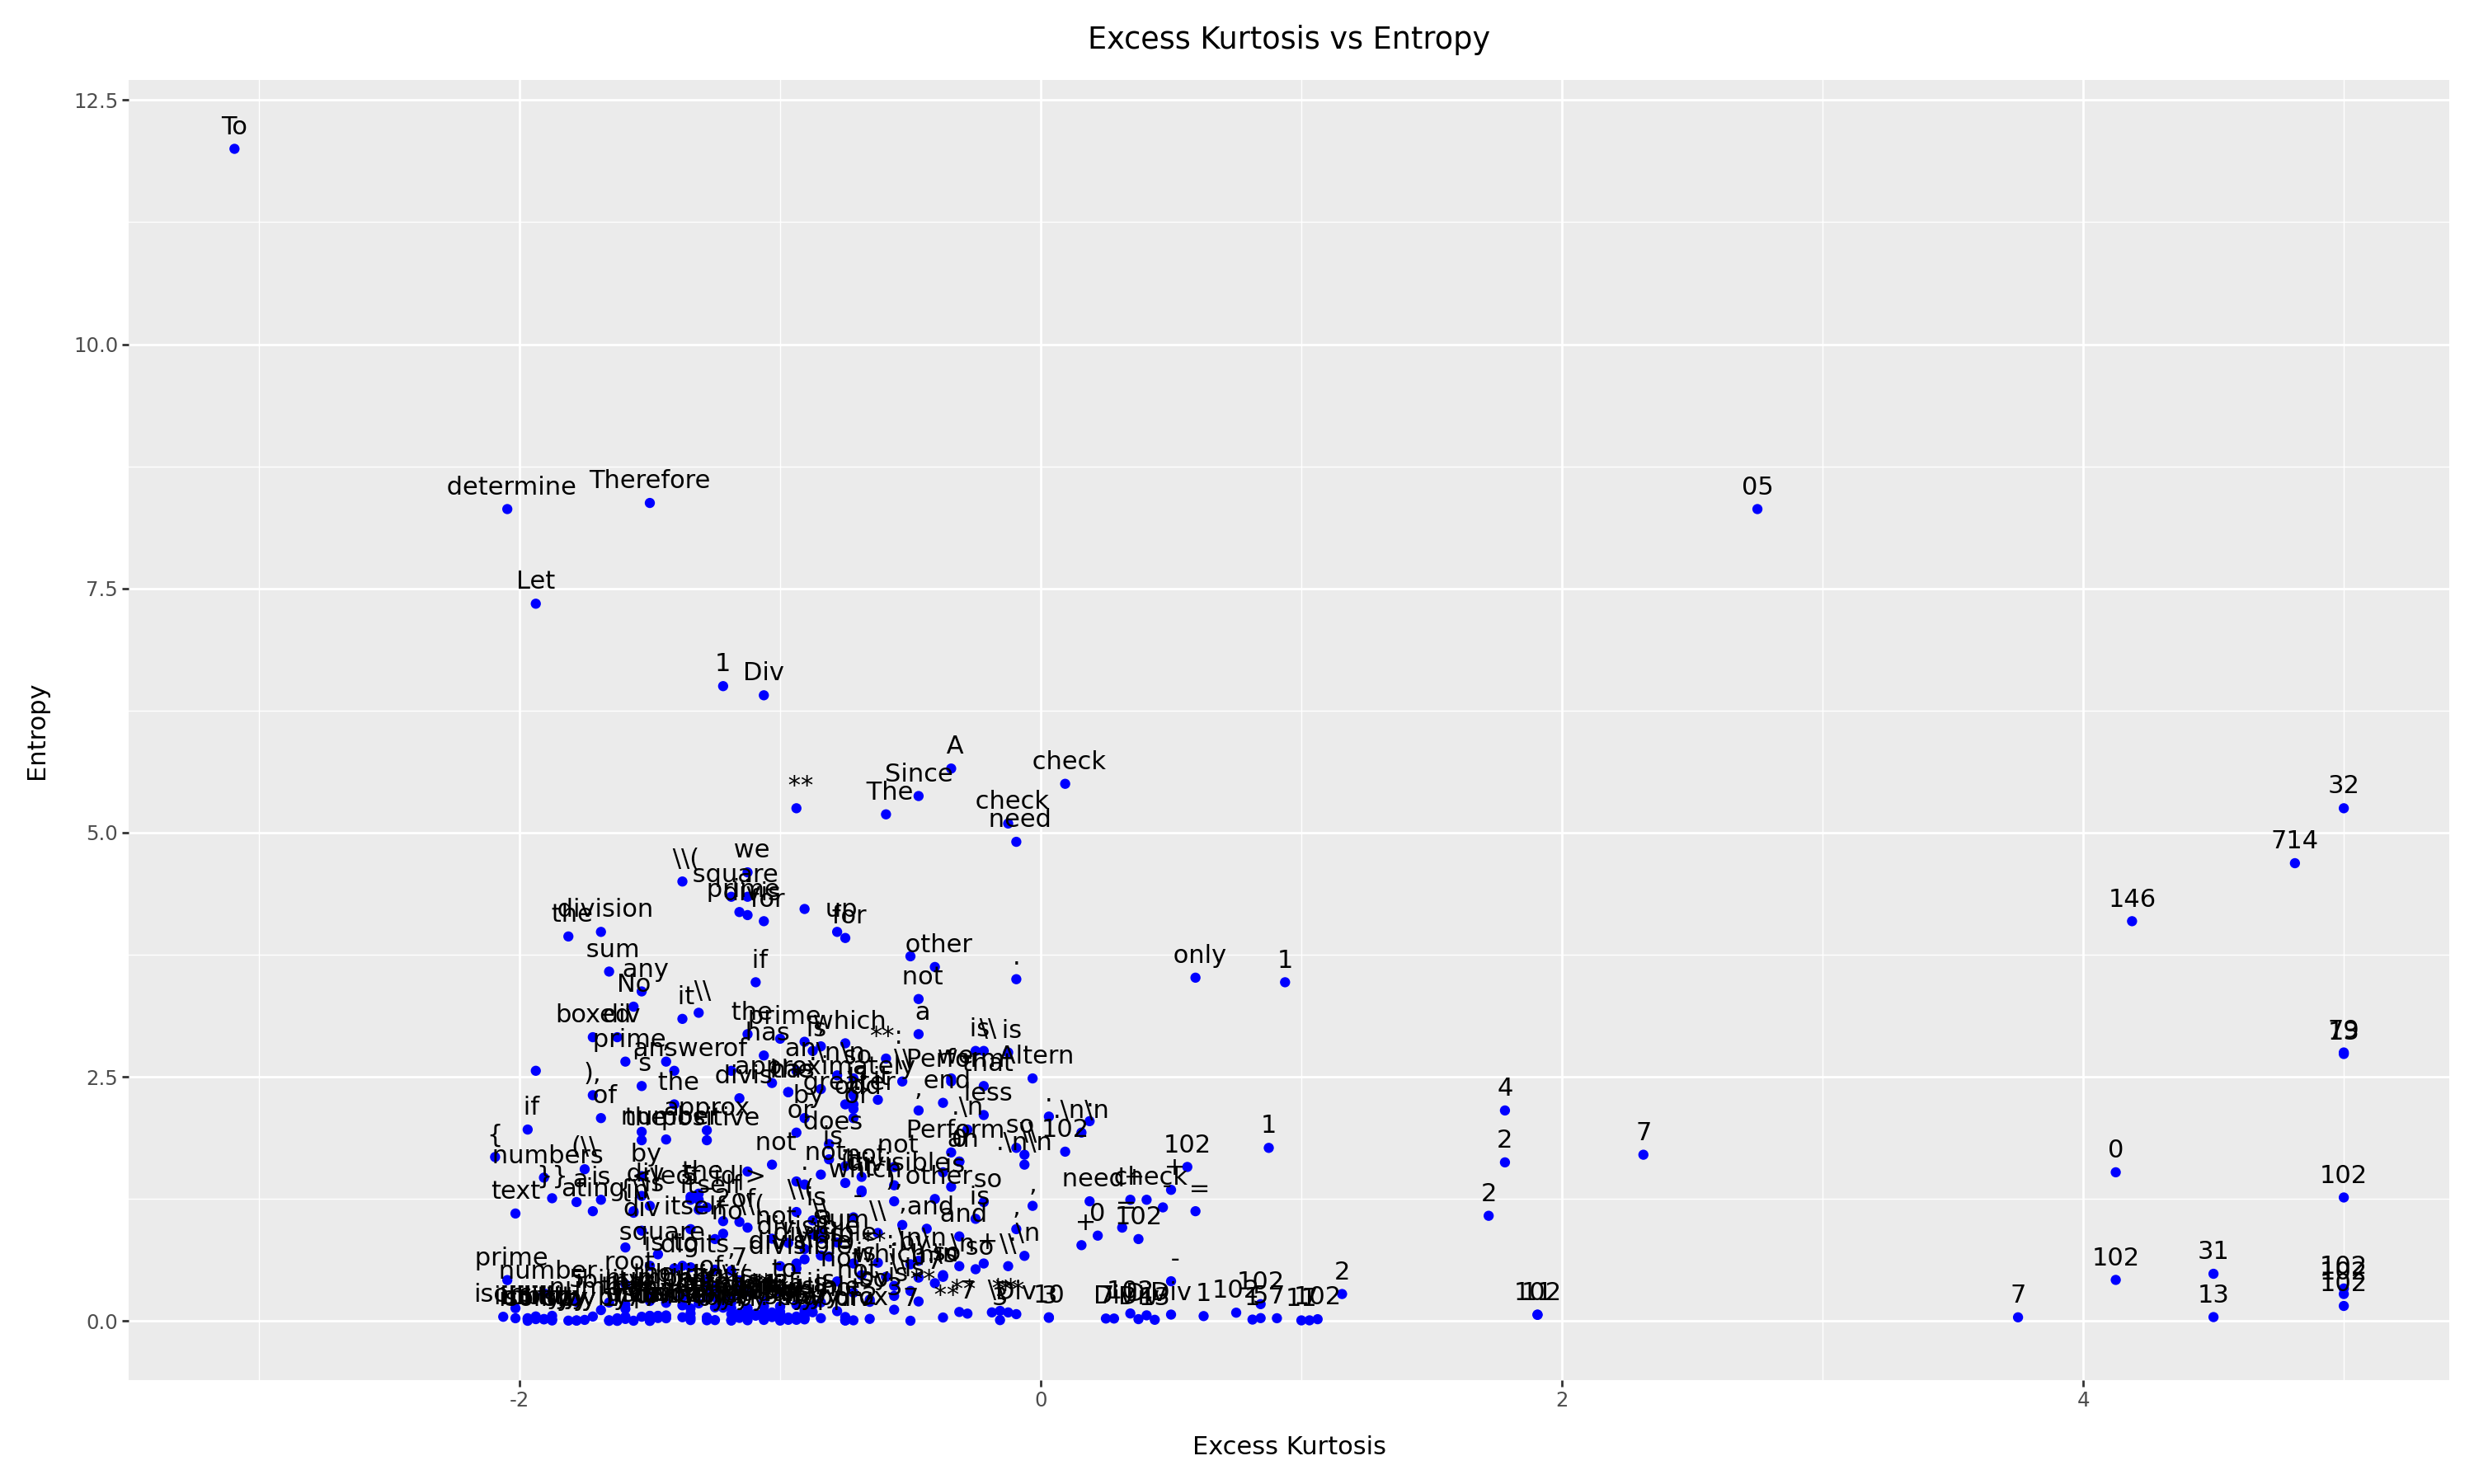

In [57]:
(pn.ggplot(df.assign(excess_kurtosis=lambda x: x['logits_kurtosis'] - 3).assign(excess_kurtosis=lambda x: x['excess_kurtosis'].clip(upper=5)),
               pn.aes(x='excess_kurtosis', 
                   y='logits_entropy')) 
    + pn.geom_point(color='blue')
    + pn.geom_text(pn.aes(label='token'), 
                va='bottom',
                ha='center',
                nudge_y=0.1)
    + pn.labs(
        title='Excess Kurtosis vs Entropy',
        x='Excess Kurtosis',
        y='Entropy'
    )
    + pn.theme(figure_size=(15, 9))
)